In [1]:
# Import numerical libraries.  
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MultiLabelBinarizer
#Librairies
import time
import torch
import random
#Raccourcis utilisé
from tqdm import tqdm_notebook
import torch.nn as nn
import torch.utils.data as data_utils
import pandas as pd

In [2]:
def to_class(y_):
    res = np.zeros((len(y_), 11), dtype='q')
    for i in range(len(y_)):
        res[i][int(y_[i])] = 1
    return res
def maximum(liste):
    maxi = liste[0]
    for i in liste:
        if i >= maxi:
            maxi = i
    return maxi
def minimum(liste):
    mini = liste[0]
    for i in liste:
        if i <= mini:
            mini = i
    return mini

In [3]:
dfX = pd.read_csv('Molecular Dataset Dream 1.csv',sep=';')
dfY = pd.read_csv('Senteur Dataset Dream 1.csv',sep=';')
df = dfX.merge(dfY)

In [4]:
list_label = ['INTENSITY/STRENGTH', 'VALENCE/PLEASANTNESS', 'BAKERY', 'SWEET',
       'FRUIT', 'FISH', 'GARLIC', 'SPICES', 'COLD', 'SOUR', 'BURNT', 'ACID',
       'WARM', 'MUSKY', 'SWEATY', 'AMMONIA/URINOUS', 'DECAYED', 'WOOD',
       'GRASS', 'FLOWER', 'CHEMICAL']

#Pour les barplot
list_label_bar = ['INTENSITY', 'VALENCE', 'BAKERY', 'SWEET',
       'FRUIT', 'FISH', 'GARLIC', 'SPICES', 'COLD', 'SOUR', 'BURNT', 'ACID',
       'WARM', 'MUSKY', 'SWEATY', 'AMMONIA', 'DECAYED', 'WOOD',
       'GRASS', 'FLOWER', 'CHEMICAL']

Dico_labels = {}
for i in range (21):
    Dico_labels[i] = list_label[i]

In [5]:
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        ## Activation layer
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(in_features = 3082, out_features = 2400)
        self.fc2 = nn.Linear(2400, 1200)  
        self.fc3 = nn.Linear(1200, 600)
        self.output = nn.Linear(600, 11)
        self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, x):
    ## First full connection
        x = self.fc1(x)
        x = self.relu(x)
    ## Second full connection
        x = self.fc2(x)
        x = self.relu(x)
    ## Third full connection
        x = self.fc3(x)
        x = self.relu(x)
    ## Output layer
        x = self.output(x)
        y = self.softmax(x)
        return y

In [6]:
#Meta parametre
LEARNING_RATE = 0.003
MOMENTUM = 0.9
N_EPOCHS = 30 
Batch = 30
# Normalisation
sc = StandardScaler()

## Prédiction du descripteur Intensité sur chacun des 49 sujets.

In [7]:
Subject_acc_Train_15, Subject_acc_Train_30 = [],[]
Subject_acc_Val_15, Subject_acc_Val_30 = [],[]
Subject_loss_Train_15, Subject_loss_Train_30 = [],[]
Subject_loss_Val_15, Subject_loss_Val_30 = [],[]

for i in range(49):
    print('Prédiction du sujet:',i+1)
    dfY = df[['INTENSITY/STRENGTH','subject']]
    dfY = dfY[df['subject']== i+1]
    dfY = dfY.drop('subject',axis=1)
    dfX = df[df['subject']== i+1]
    dfX = dfX.drop(list_label,axis=1)
    dfX = dfX.drop('Unnamed: 0',axis=1)
    dfX = dfX.drop('CID',axis=1)
    dfX = dfX.drop('subject',axis=1)
    dataX = np.float32(dfX.values)
    dataY = np.longlong(dfY.values)
    dataY = to_class(dataY)
    dataX = sc.fit_transform(dataX)
    
    DATA_Train, DATA_Test, TARGET_Train, TARGET_Test = train_test_split(dataX, dataY ,test_size=0.1)
    X_train_tensor = torch.from_numpy(DATA_Train)
    Y_train_tensor = torch.from_numpy(TARGET_Train)
    X_test_tensor = torch.from_numpy(DATA_Test)
    Y_test_tensor = torch.from_numpy(TARGET_Test)
    train = data_utils.TensorDataset(X_train_tensor, Y_train_tensor)
    train_loader = data_utils.DataLoader(train, batch_size=Batch, shuffle=True)
    test = data_utils.TensorDataset(X_test_tensor, Y_test_tensor)
    test_loader = data_utils.DataLoader(test, batch_size=Batch, shuffle=True)
    
    net = MyNetwork()
    net = net.cuda()
    criterion = nn.NLLLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)  
    epoch_loss, epoch_acc, epoch_val_loss, epoch_val_acc = [], [], [], []
    start_time = time.time()
    
    for e in range(N_EPOCHS):
        running_loss = 0
        running_accuracy = 0
        running_acc=0
        start_epoch_time=time.time()

        net.train()  
        for i, batch in enumerate(train_loader):
            x = batch[0]
            labels = batch[1]
            x = x.cuda()
            labels = labels.cuda()
            output = net(x)
            y = output  
            loss = criterion(y, torch.max(labels, 1)[1])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                running_loss += loss.item()
                running_accuracy += (y.max(1)[1] == torch.max(labels, 1)[1]).sum().item()
        epoch_loss.append(running_loss/len(train))
        epoch_acc.append(running_accuracy/len(train))
         
        net.eval()
        running_val_loss = 0
        running_val_accuracy = 0  
        for i, batch in enumerate(test_loader):
            with torch.no_grad():
                x = batch[0]
                labels = batch[1]
                x = x.cuda()
                labels = labels.cuda()
                output = net(x)
                y = output            
                loss = criterion(y, torch.max(labels, 1)[1])
                running_val_loss += loss.item()
                running_val_accuracy += (y.max(1)[1] == torch.max(labels, 1)[1]).sum().item()
        epoch_val_loss.append(running_val_loss/len(test))
        epoch_val_acc.append(running_val_accuracy/len(test))
            
        if e == 14 :
            Subject_acc_Train_15.append(maximum(epoch_acc))
            Subject_acc_Val_15.append(maximum(epoch_val_acc))
            Subject_loss_Train_15.append(minimum(epoch_loss))
            Subject_loss_Val_15.append(minimum(epoch_val_loss))
        if e == 29 :
            Subject_acc_Train_30.append(maximum(epoch_acc))
            Subject_acc_Val_30.append(maximum(epoch_val_acc))
            Subject_loss_Train_30.append(minimum(epoch_loss))
            Subject_loss_Val_30.append(minimum(epoch_val_loss))
    print('Meilleur: Acc:',maximum(epoch_acc))
    interval = time.time() - start_time
    print ('Temps total en secondes:', interval)
    del net
    print(  )

Prédiction du sujet: 1
Meilleur: Acc: 0.6496551724137931
Temps total en secondes: 8.900108098983765

Prédiction du sujet: 2
Meilleur: Acc: 0.6153846153846154
Temps total en secondes: 4.480771064758301

Prédiction du sujet: 3
Meilleur: Acc: 0.6739606126914661
Temps total en secondes: 3.726060390472412

Prédiction du sujet: 4
Meilleur: Acc: 0.710948905109489
Temps total en secondes: 5.395589828491211

Prédiction du sujet: 5
Meilleur: Acc: 0.6717724288840262
Temps total en secondes: 3.7651989459991455

Prédiction du sujet: 6
Meilleur: Acc: 0.7170418006430869
Temps total en secondes: 2.63811993598938

Prédiction du sujet: 7
Meilleur: Acc: 0.7208588957055214
Temps total en secondes: 5.137445688247681

Prédiction du sujet: 8
Meilleur: Acc: 0.61082910321489
Temps total en secondes: 4.6874823570251465

Prédiction du sujet: 9
Meilleur: Acc: 0.7553191489361702
Temps total en secondes: 3.7611331939697266

Prédiction du sujet: 10
Meilleur: Acc: 0.6559139784946236
Temps total en secondes: 2.3746714

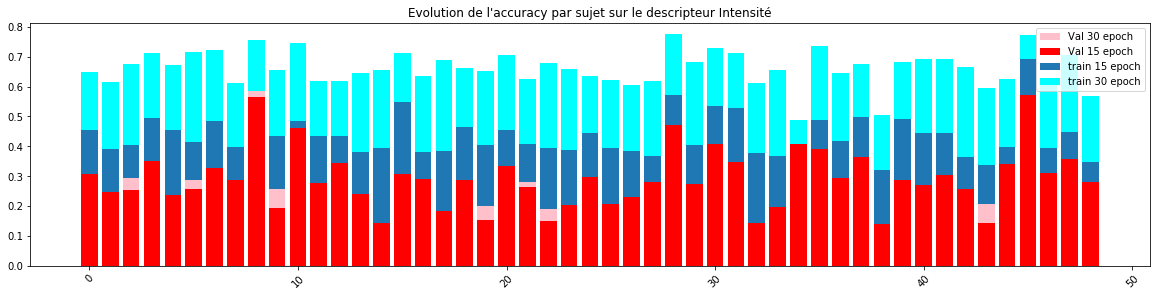

In [8]:
plt.subplots(1,figsize=(16,4),constrained_layout=True)
d = plt.bar(np.arange(49),Subject_acc_Train_30,color=['cyan'])
c = plt.bar(np.arange(49),Subject_acc_Train_15)
a = plt.bar(np.arange(49),Subject_acc_Val_30,color=['pink'])
b = plt.bar(np.arange(49),Subject_acc_Val_15,color=['red'])
plt.title("Evolution de l'accuracy par sujet sur le descripteur Intensité")
plt.legend((a,b,c,d),('Val 30 epoch','Val 15 epoch','train 15 epoch','train 30 epoch'))
plt.xticks(rotation=45)
plt.show()

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.]),
 <a list of 8 Text xticklabel objects>)

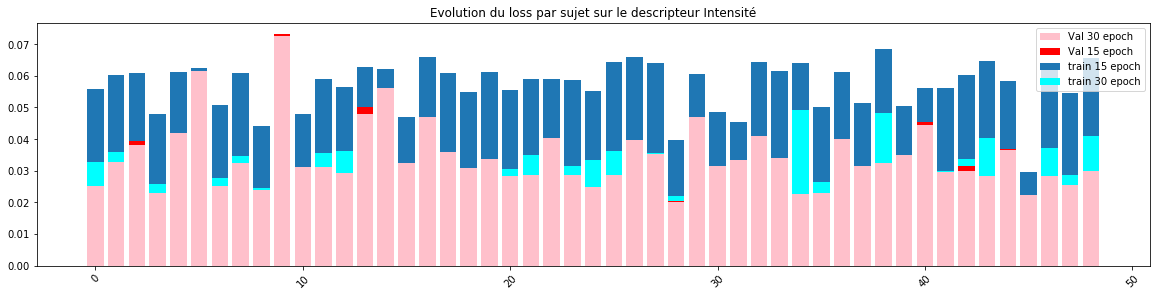

In [10]:
plt.subplots(1,figsize=(16,4),constrained_layout=True)

c = plt.bar(np.arange(49),Subject_loss_Train_15)
d = plt.bar(np.arange(49),Subject_loss_Train_30,color=['cyan'])
b = plt.bar(np.arange(49),Subject_loss_Val_15,color=['red'])
a = plt.bar(np.arange(49),Subject_loss_Val_30,color=['pink'])


plt.title("Evolution du loss par sujet sur le descripteur Intensité")
plt.legend((a,b,c,d),('Val 30 epoch','Val 15 epoch','train 15 epoch','train 30 epoch'))
plt.xticks(rotation=45)

In [17]:
Subject_acc_Train_15, Subject_acc_Train_30 = [],[]
Subject_acc_Val_15, Subject_acc_Val_30 = [],[]
Subject_loss_Train_15, Subject_loss_Train_30 = [],[]
Subject_loss_Val_15, Subject_loss_Val_30 = [],[]

for i in range(49):
    print('Prédiction du sujet:',i+1)
    
    dfY = df[['VALENCE/PLEASANTNESS','subject']]
    dfY = dfY[df['subject']== i+1]
    dfY = dfY.drop('subject',axis=1)
    
    dfX = df[df['subject']== i+1]
    dfX = dfX.drop(list_label,axis=1)
    dfX = dfX.drop('Unnamed: 0',axis=1)
    dfX = dfX.drop('CID',axis=1)
    dfX = dfX.drop('subject',axis=1)
    
    dataX = np.float32(dfX.values)
    dataY = np.longlong(dfY.values)
    dataY = to_class(dataY)
    dataX = sc.fit_transform(dataX)
    
    DATA_Train, DATA_Test, TARGET_Train, TARGET_Test = train_test_split(dataX, dataY ,test_size=0.1)
    
    Batch = 30
    X_train_tensor = torch.from_numpy(DATA_Train)
    Y_train_tensor = torch.from_numpy(TARGET_Train)

    X_test_tensor = torch.from_numpy(DATA_Test)
    Y_test_tensor = torch.from_numpy(TARGET_Test)

    train = data_utils.TensorDataset(X_train_tensor, Y_train_tensor)
    train_loader = data_utils.DataLoader(train, batch_size=Batch, shuffle=True)

    test = data_utils.TensorDataset(X_test_tensor, Y_test_tensor)
    test_loader = data_utils.DataLoader(test, batch_size=Batch, shuffle=True)
    
    net = MyNetwork()
    net = net.cuda()

    LEARNING_RATE = 0.003
    MOMENTUM = 0.9

    criterion = nn.NLLLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
    
    N_EPOCHS = 20    
    epoch_loss, epoch_acc, epoch_val_loss, epoch_val_acc = [], [], [], []
    start_time = time.time()
    
    for e in range(N_EPOCHS):
        
        ### boucle d'entraineement
        running_loss = 0
        running_accuracy = 0
        running_acc=0
        start_epoch_time=time.time()
        
        ## Le réseau est mis en mode "entrainement"
        net.train()
        
        for i, batch in enumerate(train_loader):
            
            # Obtenir batch du dataloader
            x = batch[0]
            labels = batch[1]

            # déplacer le batch sur le GPU
            x = x.cuda()
            labels = labels.cuda()

            # Calcul de l'output et les loss
            output = net(x)
            y = output
            
            loss = criterion(y, torch.max(labels, 1)[1])
            
            # Réinitialisation du gradients
            optimizer.zero_grad()
            
            # Calculs du gradients
            loss.backward()
            
            # Appliquecation d'une étape d'optimisation de l'algorithme de descente pour mettre à jour les poids
            optimizer.step()
            
            with torch.no_grad():
                running_loss += loss.item()
                running_accuracy += (y.max(1)[1] == torch.max(labels, 1)[1]).sum().item()
                
        epoch_loss.append(running_loss/len(train))
        epoch_acc.append(running_accuracy/len(train))
         
        ### Boucle de valisation
        ## Le réseau est mis en mode validation
        net.eval()
        running_val_loss = 0
        running_val_accuracy = 0

                
        for i, batch in enumerate(test_loader):
            with torch.no_grad():
                x = batch[0]
                labels = batch[1]
                x = x.cuda()
                labels = labels.cuda()
                output = net(x)
                y = output
            
                loss = criterion(y, torch.max(labels, 1)[1])
                running_val_loss += loss.item()
                running_val_accuracy += (y.max(1)[1] == torch.max(labels, 1)[1]).sum().item()

        epoch_val_loss.append(running_val_loss/len(test))
        epoch_val_acc.append(running_val_accuracy/len(test))
        if e == 9 :
            Subject_acc_Train_15.append(maximum(epoch_acc))
            Subject_acc_Val_15.append(maximum(epoch_val_acc))
            Subject_loss_Train_15.append(minimum(epoch_loss))
            Subject_loss_Val_15.append(minimum(epoch_val_loss))

        if e == 19 :
            Subject_acc_Train_30.append(maximum(epoch_acc))
            Subject_acc_Val_30.append(maximum(epoch_val_acc))
            Subject_loss_Train_30.append(minimum(epoch_loss))
            Subject_loss_Val_30.append(minimum(epoch_val_loss))

    print('Meilleur: Acc:',maximum(epoch_acc))
    interval = time.time() - start_time
    print ('Temps total en secondes:', interval)
    del net

    print(  )

Prédiction du sujet: 1
Meilleur: Acc: 0.45694444444444443
Temps total en secondes: 3.9986839294433594

Prédiction du sujet: 2
Meilleur: Acc: 0.4953959484346225
Temps total en secondes: 3.196033239364624

Prédiction du sujet: 3
Meilleur: Acc: 0.43612334801762115
Temps total en secondes: 2.6577200889587402

Prédiction du sujet: 4
Meilleur: Acc: 0.5602941176470588
Temps total en secondes: 3.912060499191284

Prédiction du sujet: 5
Meilleur: Acc: 0.45714285714285713
Temps total en secondes: 2.6797826290130615

Prédiction du sujet: 6
Meilleur: Acc: 0.6828478964401294
Temps total en secondes: 1.8461313247680664

Prédiction du sujet: 7
Meilleur: Acc: 0.4876543209876543
Temps total en secondes: 3.817798376083374

Prédiction du sujet: 8
Meilleur: Acc: 0.45733788395904434
Temps total en secondes: 3.35745906829834

Prédiction du sujet: 9
Meilleur: Acc: 0.532051282051282
Temps total en secondes: 2.6555047035217285

Prédiction du sujet: 10
Meilleur: Acc: 0.5018050541516246
Temps total en secondes: 1

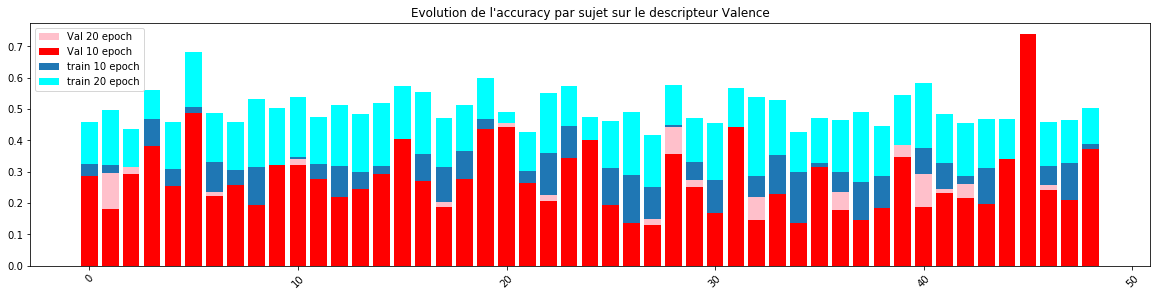

In [18]:
plt.subplots(1,figsize=(16,4),constrained_layout=True)

d = plt.bar(np.arange(49),Subject_acc_Train_30,color=['cyan'])
c = plt.bar(np.arange(49),Subject_acc_Train_15)
a = plt.bar(np.arange(49),Subject_acc_Val_30,color=['pink'])
b = plt.bar(np.arange(49),Subject_acc_Val_15,color=['red'])
plt.title("Evolution de l'accuracy par sujet sur le descripteur Valence")
plt.legend((a,b,c,d),('Val 20 epoch','Val 10 epoch','train 10 epoch','train 20 epoch'))
plt.xticks(rotation=45)
plt.show()

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.]),
 <a list of 8 Text xticklabel objects>)

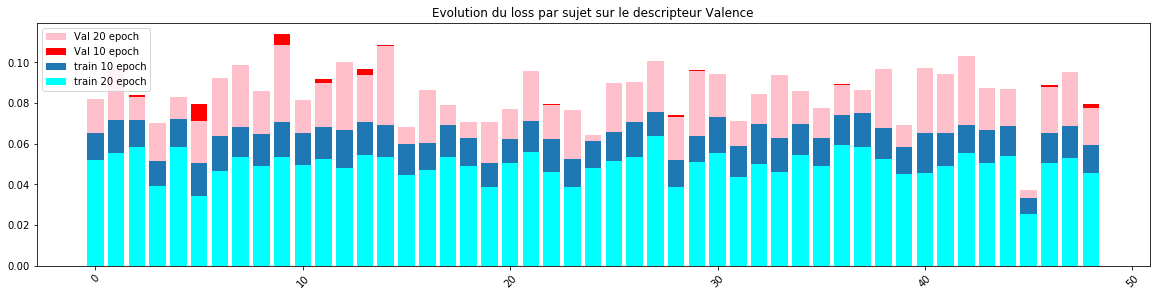

In [21]:
plt.subplots(1,figsize=(16,4),constrained_layout=True)

b = plt.bar(np.arange(49),Subject_loss_Val_15,color=['red'])
a = plt.bar(np.arange(49),Subject_loss_Val_30,color=['pink'])
c = plt.bar(np.arange(49),Subject_loss_Train_15)
d = plt.bar(np.arange(49),Subject_loss_Train_30,color=['cyan'])
plt.title("Evolution du loss par sujet sur le descripteur Valence")
plt.legend((a,b,c,d),('Val 20 epoch','Val 10 epoch','train 10 epoch','train 20 epoch'))
plt.xticks(rotation=45)

In [16]:
Subject_acc_Train_15, Subject_acc_Train_30 = [],[]
Subject_acc_Val_15, Subject_acc_Val_30 = [],[]
Subject_loss_Train_15, Subject_loss_Train_30 = [],[]
Subject_loss_Val_15, Subject_loss_Val_30 = [],[]

for i in range(49):
    print('Prédiction du sujet:',i+1)
    
    dfY = df[['SWEET','subject']]
    dfY = dfY[df['subject']== i+1]
    dfY = dfY.drop('subject',axis=1)
    
    dfX = df[df['subject']== i+1]
    dfX = dfX.drop(list_label,axis=1)
    dfX = dfX.drop('Unnamed: 0',axis=1)
    dfX = dfX.drop('CID',axis=1)
    dfX = dfX.drop('subject',axis=1)
    
    dataX = np.float32(dfX.values)
    dataY = np.longlong(dfY.values)
    dataY = to_class(dataY)
    dataX = sc.fit_transform(dataX)
    
    DATA_Train, DATA_Test, TARGET_Train, TARGET_Test = train_test_split(dataX, dataY ,test_size=0.1)
    
    Batch = 30
    X_train_tensor = torch.from_numpy(DATA_Train)
    Y_train_tensor = torch.from_numpy(TARGET_Train)

    X_test_tensor = torch.from_numpy(DATA_Test)
    Y_test_tensor = torch.from_numpy(TARGET_Test)

    train = data_utils.TensorDataset(X_train_tensor, Y_train_tensor)
    train_loader = data_utils.DataLoader(train, batch_size=Batch, shuffle=True)

    test = data_utils.TensorDataset(X_test_tensor, Y_test_tensor)
    test_loader = data_utils.DataLoader(test, batch_size=Batch, shuffle=True)
    
    net = MyNetwork()
    net = net.cuda()

    LEARNING_RATE = 0.003
    MOMENTUM = 0.9

    criterion = nn.NLLLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
    
    N_EPOCHS = 30    
    
    epoch_loss, epoch_acc, epoch_val_loss, epoch_val_acc = [], [], [], []
    start_time = time.time()
    
    for e in range(N_EPOCHS):
        
        ### boucle d'entraineement
        running_loss = 0
        running_accuracy = 0
        running_acc=0
        start_epoch_time=time.time()
        
        ## Le réseau est mis en mode "entrainement"
        net.train()
        
        for i, batch in enumerate(train_loader):
            
            # Obtenir batch du dataloader
            x = batch[0]
            labels = batch[1]

            # déplacer le batch sur le GPU
            x = x.cuda()
            labels = labels.cuda()

            # Calcul de l'output et les loss
            output = net(x)
            y = output
            
            loss = criterion(y, torch.max(labels, 1)[1])
            
            # Réinitialisation du gradients
            optimizer.zero_grad()
            
            # Calculs du gradients
            loss.backward()
            
            # Appliquecation d'une étape d'optimisation de l'algorithme de descente pour mettre à jour les poids
            optimizer.step()
            
            with torch.no_grad():
                running_loss += loss.item()
                running_accuracy += (y.max(1)[1] == torch.max(labels, 1)[1]).sum().item()
                
        epoch_loss.append(running_loss/len(train))
        epoch_acc.append(running_accuracy/len(train))
         
        ### Boucle de valisation
        ## Le réseau est mis en mode validation
        net.eval()
        running_val_loss = 0
        running_val_accuracy = 0

                
        for i, batch in enumerate(test_loader):
            with torch.no_grad():
                x = batch[0]
                labels = batch[1]
                x = x.cuda()
                labels = labels.cuda()
                output = net(x)
                y = output
            
                loss = criterion(y, torch.max(labels, 1)[1])
                running_val_loss += loss.item()
                running_val_accuracy += (y.max(1)[1] == torch.max(labels, 1)[1]).sum().item()

        epoch_val_loss.append(running_val_loss/len(test))
        epoch_val_acc.append(running_val_accuracy/len(test))
        if e == 14 :
            Subject_acc_Train_15.append(maximum(epoch_acc))
            Subject_acc_Val_15.append(maximum(epoch_val_acc))
            Subject_loss_Train_15.append(minimum(epoch_loss))
            Subject_loss_Val_15.append(minimum(epoch_val_loss))

        if e == 29 :
            Subject_acc_Train_30.append(maximum(epoch_acc))
            Subject_acc_Val_30.append(maximum(epoch_val_acc))
            Subject_loss_Train_30.append(minimum(epoch_loss))
            Subject_loss_Val_30.append(minimum(epoch_val_loss))

    print('Meilleur: Acc:',maximum(epoch_acc))
    interval = time.time() - start_time
    print ('Temps total en secondes:', interval)
    del net

    print(  )

Prédiction du sujet: 1
Meilleur: Acc: 0.7103448275862069
Temps total en secondes: 5.802255630493164

Prédiction du sujet: 2
Meilleur: Acc: 0.684981684981685
Temps total en secondes: 4.463259696960449

Prédiction du sujet: 3
Meilleur: Acc: 0.7768052516411379
Temps total en secondes: 3.663076400756836

Prédiction du sujet: 4
Meilleur: Acc: 0.964963503649635
Temps total en secondes: 5.3151984214782715

Prédiction du sujet: 5
Meilleur: Acc: 0.849015317286652
Temps total en secondes: 3.666400909423828

Prédiction du sujet: 6
Meilleur: Acc: 0.8778135048231511
Temps total en secondes: 2.577871799468994

Prédiction du sujet: 7
Meilleur: Acc: 0.6426380368098159
Temps total en secondes: 4.969362497329712

Prédiction du sujet: 8
Meilleur: Acc: 0.8950930626057529
Temps total en secondes: 4.663632869720459

Prédiction du sujet: 9
Meilleur: Acc: 0.8127659574468085
Temps total en secondes: 3.6194183826446533

Prédiction du sujet: 10
Meilleur: Acc: 0.7777777777777778
Temps total en secondes: 2.3015401

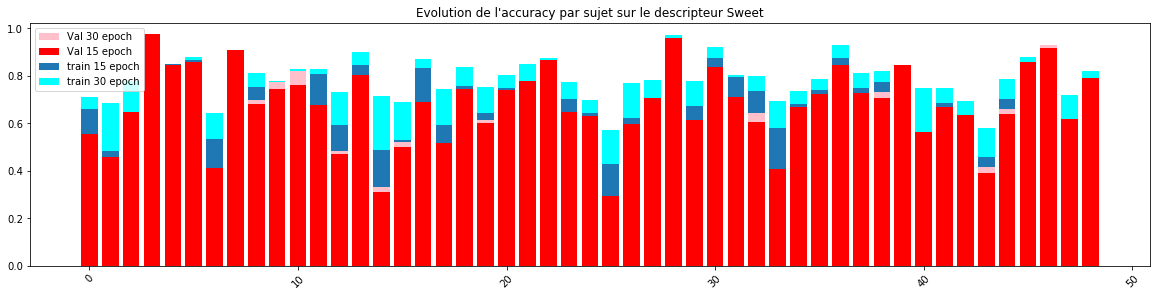

In [17]:
plt.subplots(1,figsize=(16,4),constrained_layout=True)

d = plt.bar(np.arange(49),Subject_acc_Train_30,color=['cyan'])
c = plt.bar(np.arange(49),Subject_acc_Train_15)
a = plt.bar(np.arange(49),Subject_acc_Val_30,color=['pink'])
b = plt.bar(np.arange(49),Subject_acc_Val_15,color=['red'])
plt.title("Evolution de l'accuracy par sujet sur le descripteur Sweet")
plt.legend((a,b,c,d),('Val 30 epoch','Val 15 epoch','train 15 epoch','train 30 epoch'))
plt.xticks(rotation=45)
plt.show()

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.]),
 <a list of 8 Text xticklabel objects>)

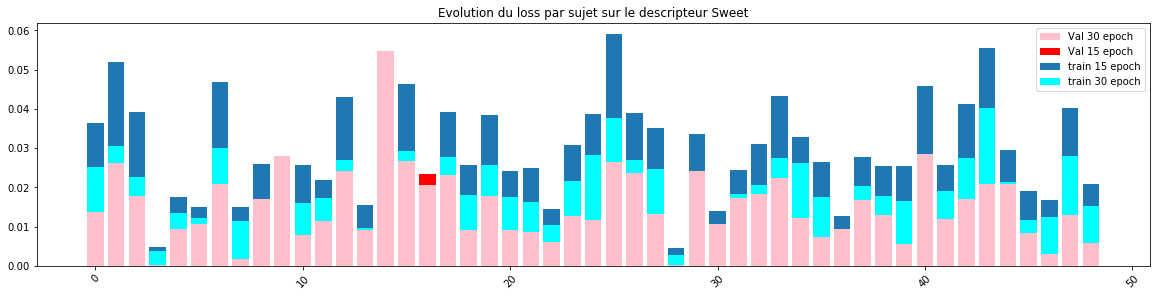

In [18]:
plt.subplots(1,figsize=(16,4),constrained_layout=True)

b = plt.bar(np.arange(49),Subject_loss_Val_15,color=['red'])
c = plt.bar(np.arange(49),Subject_loss_Train_15)
d = plt.bar(np.arange(49),Subject_loss_Train_30,color=['cyan'])
a = plt.bar(np.arange(49),Subject_loss_Val_30,color=['pink'])
plt.title("Evolution du loss par sujet sur le descripteur Sweet")
plt.legend((a,b,c,d),('Val 30 epoch','Val 15 epoch','train 15 epoch','train 30 epoch'))
plt.xticks(rotation=45)